# Improvements to make:

1. Calculate terms in the continuity equation.
2. Look at some numbers from NON snow dates - don't need to worry about instrument height.
3. Duplicate/interpolate density (and mixing ratio) measurements across the towers in a more sophisticated way (currently using ground-relative height, should be using snow-surface-relative height).
4. Looking at moisture/water vapor data at downvalley sites - KPS annex site? Brush Creek

T should be in kelvin

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('jupyterlab')
from sublimpy import tidy, utils
import pytz
import datetime as dt

seconds_in_timestep = 60*30
from metpy.constants import density_water

from metpy.units import units
import pint_pandas
from metpy import constants
from scipy import interpolate
np.set_printoptions(suppress=True,precision=10)

# Parameters for calculations

In [2]:
HEIGHTS = [1,3,10]
HORIZ_GRID_SPACING = 50
VERT_GRID_SPACING = 20
# start_date = '20221130'
# end_date = '20230509'
start_date = '20221101'
end_date = '20230619'

# data_cutoff_date = '20230508'
data_cutoff_date = '20230619'

    # streamwise coordinates
# tidy_df = pd.read_parquet(f"tidy_df_{start_date}_{end_date}_planar_fit_multiplane.parquet")
    # slope relative local earth coodinates
# tidy_df = pd.read_parquet(f"tidy_df_{start_date}_{end_date}_planar_fit.parquet")
    # seemingly local earth coodinates
tidy_df = pd.read_parquet(f"tidy_df_{start_date}_{end_date}_noplanar_fit.parquet")


In [3]:
# convert time column to datetime
# tidy_df['time'] = pd.to_datetime(tidy_df['time'])
tidy_df = utils.modify_df_timezone(tidy_df, 'UTC', 'US/Mountain')
# limit data to our dates of interest, based on continuous snow cover at Kettle Ponds
tidy_df = tidy_df.set_index('time').sort_index().loc[start_date:data_cutoff_date].reset_index()
# tidy_df = tidy_df.drop_duplicates()

## Add absolute humidity measurements by converting hygrometer measurements

In [4]:
tower_height_keys = tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height']).indices.keys()
for t, h in tower_height_keys:
    this_tower_height_tidy_df = tidy_df.query(
            f"tower == '{t}'"
        ).query(
            f"height == {h}"
        )
    specific_humidity_values = this_tower_height_tidy_df.query(
            "measurement == 'specific humidity'"
        ).set_index('time')[['value']].rename(columns={'value': 'specific humidity'})
    air_density_values = this_tower_height_tidy_df.query(
            "measurement == 'air density'"
        ).set_index('time')[['value']].rename(columns={'value': 'air density'})
    combined_df = specific_humidity_values.join(air_density_values)
    #WHY DO I HAVE TO DO THIS????
    combined_df = combined_df.reset_index().drop_duplicates('time')
    abs_humidity_values = (
        combined_df['specific humidity'].values * units('g/g')
    ).to('g/kg') * (
        combined_df['air density'].values * units('kg/m^3')
    ).m

    tidy_df = tidy.tidy_df_add_variable(
        tidy_df,
        abs_humidity_values,
        f"absolutehumidity_{int(h)}m_{t}",
        'absolute humidity',
        int(h),
        t
    )

## Calibrate gas analyzer measurements

We calibrate by assuming that all gas analyzers have the same seasonal mean as the corresponding hygrometer measurement on the central tower (at a given height)

### With seasonal mean

In [5]:
hygrometer_absolute_humidity_mean = (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
).reset_index().query("tower == 'c'")

In [6]:
ec_absolute_humidity_mean = tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()

In [7]:
corrections_df = ec_absolute_humidity_mean.merge(
    hygrometer_absolute_humidity_mean[['height', 'value']].rename(columns={'value': 'truth'}),
    on='height'
)
corrections_df['offset'] = corrections_df['value'] - corrections_df['truth']
corrections_df

,variable,tower,height,value,truth,offset
0,h2o_10m_c,c,10.0,2.524665,2.487664,0.037000
1,h2o_10m_d,d,10.0,1.777192,2.487664,-0.710472
2,h2o_10m_ue,ue,10.0,1.466298,2.487664,-1.021366
3,h2o_10m_uw,uw,10.0,2.096407,2.487664,-0.391257
4,h2o_15m_c,c,15.0,2.289604,2.466423,-0.176820
5,h2o_1m_c,c,1.0,2.840210,2.644168,0.196042
6,h2o_1m_d,d,1.0,2.035098,2.644168,-0.609070
7,h2o_1m_ue,ue,1.0,2.150399,2.644168,-0.493769
8,h2o_1m_uw,uw,1.0,2.425554,2.644168,-0.218614
9,h2o_20m_c,c,20.0,1.255368,2.452797,-1.197429


Update dataset with corrections

In [8]:
src = tidy_df[tidy_df.measurement=='Water vapor density']
src = src[src.height.isin([1,3,10])]
src

,time,variable,value,height,tower,measurement
77,2022-11-01 00:00:00,h2o_3m_ue,2.575798,3.0,ue,Water vapor density
104,2022-11-01 00:00:00,h2o_10m_d,1.920190,10.0,d,Water vapor density
289,2022-11-01 00:00:00,h2o_1m_d,2.311011,1.0,d,Water vapor density
320,2022-11-01 00:00:00,h2o_10m_uw,2.390329,10.0,uw,Water vapor density
478,2022-11-01 00:00:00,h2o_1m_ue,2.032952,1.0,ue,Water vapor density
...,...,...,...,...,...,...
9580274,2023-06-19 17:30:00,h2o_3m_d,3.101750,3.0,d,Water vapor density
9580296,2023-06-19 17:30:00,h2o_10m_d,2.669686,10.0,d,Water vapor density
9580306,2023-06-19 17:30:00,h2o_3m_c,2.461334,3.0,c,Water vapor density
9580408,2023-06-19 17:30:00,h2o_1m_uw,3.362670,1.0,uw,Water vapor density


In [9]:
alt.Chart(
    (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
    ).reset_index()
).mark_point(shape='square', filled=True, color='black', size=20).encode(
    alt.X("value:Q"),
    alt.Y("height:Q")
).properties(width=150, height = 150)\
+ alt.Chart(
    tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
).mark_circle(size=40).encode(
    alt.X("value:Q"),
    alt.Y("height:Q"),
    alt.Color('tower:N')
).properties(width=150, height = 150)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [10]:


alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("height:N"),
    detail='variable'
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_13412/1085128452.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[ src.time > '20221212' ][ src.time < '20221214' ]


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [11]:
for idx, row in corrections_df.iterrows():
    src = tidy_df.query(f"variable == '{row['variable']}'")
    src = src.assign(value = src.value - row['offset'])
    tidy_df = tidy_df[tidy_df.variable != row['variable']]
    tidy_df = pd.concat([tidy_df, src])

In [12]:
alt.Chart(
    (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
    ).reset_index()
).mark_point(shape='square', filled=True, color='black', size=20).encode(
    alt.X("value:Q"),
    alt.Y("height:Q")
).properties(width=150, height = 150)\
+ alt.Chart(
    tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
).mark_circle(size=40).encode(
    alt.X("value:Q"),
    alt.Y("height:Q"),
    alt.Color('tower:N')
).properties(width=150, height = 150)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [13]:
src = tidy_df[tidy_df.measurement=='Water vapor density']
src = src[src.height.isin([1,3,10])]
abs_hum = alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line(strokeWidth=0.5).encode(
    alt.X("time:T"),
    alt.Y("value:Q").title("Absolute humidity (g/m^3)").scale(zero=False),
    alt.Color("height:N"),
    alt.Shape('tower:N'),
    detail='variable'
).properties(width=600)

src = tidy_df[tidy_df.measurement=='snow depth']
snowdepth = alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line(strokeWidth=0.5).encode(
    alt.X("time:T"),
    alt.Y("value:Q").title("Snow depth (m)"),
    alt.Shape('tower:N'),
    detail='variable'
).properties(width=600, height=150)

(snowdepth & abs_hum).resolve_scale(color='independent', shape='independent')

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_13412/427924892.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[ src.time > '20221212' ][ src.time < '20221214' ]
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_13412/427924892.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[ src.time > '20221212' ][ src.time < '20221214' ]


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


### With monthly means

In [14]:
# filtered_spechumidity = tidy_df[tidy_df.measurement=='specific humidity']
# hygrometer_absolute_humidity_mean = (
#     1000 * filtered_spechumidity.groupby(['tower', 'height', filtered_spechumidity.time.dt.month])[['value']].mean() *\
#     tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
# ).reset_index().query("tower == 'c'")

In [15]:
# filtered_abshumidity = tidy_df[tidy_df.measurement=='Water vapor density']
# ec_absolute_humidity_mean = filtered_abshumidity.groupby([
#     'variable', 'tower', 'height', filtered_abshumidity.time.dt.month
# ])[['value']].mean().reset_index()
# ec_absolute_humidity_mean

In [16]:
# corrections_df = ec_absolute_humidity_mean.merge(
#     hygrometer_absolute_humidity_mean[['height', 'value', 'time', 'tower']].rename(columns={'value': 'truth'}),
#     on=['height', 'tower', 'time']
# )
# corrections_df['offset'] = corrections_df['value'] - corrections_df['truth']


Update dataset with corrections

In [17]:
# corrected_measurements = []
# for variable in corrections_df.variable.unique():
#     for month in corrections_df[corrections_df.variable == variable].time.unique():
#         src = tidy_df.query(f"variable == '{variable}'")
#         src = src[src.time.dt.month == month]
#         row = corrections_df.set_index(['variable', 'time']).loc[variable, month]
#         src = src.assign(value = src.value - row['offset'])
#         corrected_measurements.append(src)

In [18]:
# for variable in corrections_df.variable.unique():
#     tidy_df = tidy_df[tidy_df.variable != variable]
# tidy_df = pd.concat([tidy_df] + corrected_measurements)

In [19]:
# hygr_vals = (
#     1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
#     tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
#     ).reset_index()
# irga_vals = tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
# hygr_vals = hygr_vals[hygr_vals.time.dt.month==12]
# irga_vals = irga_vals[irga_vals.time.dt.month==12]
# alt.Chart(hygr_vals).mark_point(shape='square', filled=True, color='black', size=20).encode(
#     alt.X("value:Q"),
#     alt.Y("height:Q")
# ).properties(width=150, height = 150)\
# + alt.Chart(irga_vals).mark_circle(size=40).encode(
#     alt.X("value:Q"),
#     alt.Y("height:Q"),
#     alt.Color('tower:N')
# ).properties(width=150, height = 150)

# Identify categories for timestamps

In [20]:
# Identify lists of timestamps for different categories
bs_times = tidy_df.query("variable == 'SF_avg_ue'").query("value > 0").time
nobs_times = tidy_df.query("variable == 'SF_avg_ue'").query("value == 0").time

decoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value < 0.43").time
weaklycoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value >= 0.43").query("value <= 0.61").time
coupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value > 0.61").time

ri_stable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value > 0.25").time
ri_unstable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value < -0.01").time
ri_neutral_times = tidy_df.query("variable == 'Ri_3m_c'").query("value >= -0.01").query("value <= 0.25").time

tgrad_stable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value > 0.01").time
tgrad_unstable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value < -0.01").time
tgrad_neutral_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value >= -0.01").query("value <= 0.01").time

december_times = tidy_df[tidy_df.time.dt.month == 12].time
january_times = tidy_df[tidy_df.time.dt.month == 1].time
february_times = tidy_df[tidy_df.time.dt.month == 2].time
march_times = tidy_df[tidy_df.time.dt.month == 3].time
april_times = tidy_df[tidy_df.time.dt.month == 4].time

midwinter_times = tidy_df[tidy_df.time < '20230320'].time
spring_times = tidy_df[tidy_df.time > '20230320'].time

In [21]:
precip_df = xr.open_dataset("/Users/elischwat/Development/data/sublimationofsnow/precip_danny/precipitation_rate_gts_w23.nc")['corrected_prcp_rate_m2'].to_dataframe()

is_snowing_dates = pd.concat([
    precip_df.query("corrected_prcp_rate_m2 > 0").index.to_series(),
    precip_df.query("corrected_prcp_rate_m2 > 0").index.to_series() + dt.timedelta(minutes=30)
])
    
is_not_snowing_dates = pd.concat([
    precip_df.query("corrected_prcp_rate_m2 <= 0").index.to_series(),
    precip_df.query("corrected_prcp_rate_m2 <= 0").index.to_series() + dt.timedelta(minutes=30)
])

# Create tables

## Instrument location info (georeferenced)
We use a file with theodolite/GPS readings provided by NCAR. 

In [22]:
instrument_loc_df = pd.read_csv("~/Development/data/sublimationofsnow/SOSm.txt", names = ['ec', 'x', 'y', 'z'])
instrument_loc_df = instrument_loc_df[ 
    instrument_loc_df['ec'].str.startswith('CS')
    |
    instrument_loc_df['ec'].str.startswith('DS') 
    |
    instrument_loc_df['ec'].str.startswith('UWS') 
    |
    instrument_loc_df['ec'].str.startswith('UES') 
]
instrument_loc_df = instrument_loc_df[ 
    instrument_loc_df['ec'].str.endswith('T') 
    |
    instrument_loc_df['ec'].str.endswith('B') 
]
instrument_loc_df['top or bottom'] = instrument_loc_df['ec'].str[-1]
instrument_loc_df['tower'] = instrument_loc_df['ec'].apply(lambda str: str.split('S')[0].lower())
instrument_loc_df['height'] = instrument_loc_df['ec'].apply(lambda str: int(str.split('S')[1][:-1]))
instrument_loc_df = instrument_loc_df.drop(columns='ec')
instrument_loc_df = instrument_loc_df.pivot(index=['height', 'tower'], columns='top or bottom').reset_index()
instrument_loc_df = instrument_loc_df.set_index(['height', 'tower']).groupby(level=0, axis=1).mean()
instrument_loc_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_13412/3668931392.py:21: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  instrument_loc_df = instrument_loc_df.set_index(['height', 'tower']).groupby(level=0, axis=1).mean()


x             y           z
height tower                                        
1      c      329002.47110  4.312171e+06  2861.36010
       d      329016.77615  4.312158e+06  2860.09135
       ue     329005.76010  4.312190e+06  2862.19275
       uw     328983.46715  4.312165e+06  2860.54055
2      c      329002.49025  4.312171e+06  2862.28475
3      c      329002.53920  4.312171e+06  2863.30060
       d      329016.82015  4.312158e+06  2862.02455
       ue     329005.80410  4.312190e+06  2864.12270
       uw     328983.52075  4.312165e+06  2862.50290
5      c      329002.53790  4.312171e+06  2865.33380
10     c      329002.65185  4.312171e+06  2870.36580
       d      329016.90980  4.312158e+06  2868.59560
       ue     329005.87765  4.312190e+06  2870.70875
       uw     328983.59905  4.312165e+06  2869.09490
15     c      329002.72120  4.312171e+06  2875.37755
20     c      329002.80045  4.312171e+06  2880.25445

In [23]:
import geopandas as gpd
gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(
        instrument_loc_df.loc[3].x,
        instrument_loc_df.loc[3].y
    ),
    crs='EPSG:32613'
).to_file("~/Downloads/tower_locs.geojson")

## Wind field measurements

In [24]:
wind_field_df = tidy_df[tidy_df.measurement.isin(['u','v','w']) & tidy_df.height.isin(HEIGHTS)]
wind_field_df = round(wind_field_df.pivot_table(index='time', columns=['height', 'tower', 'measurement'], values='value'), 4)
wind_field_df

height                 1.0                                                   \
tower                     c                       d                      ue   
measurement               u       v       w       u       v       w       u   
time                                                                          
2022-11-01 00:00:00  0.0866 -0.6911  0.0403  0.0367 -0.7525  0.0306  0.0443   
2022-11-01 00:30:00  0.5442 -1.6472  0.0165  0.5243 -1.4512  0.0057  0.4870   
2022-11-01 01:00:00  0.5346 -0.8556  0.0226  0.4851 -0.7125  0.0138  0.4988   
2022-11-01 01:30:00  0.9003 -1.4850  0.0114  0.8566 -1.2743  0.0143  0.8837   
2022-11-01 02:00:00  0.9737 -1.7045  0.0086  1.0091 -1.5010  0.0028  0.9485   
...                     ...     ...     ...     ...     ...     ...     ...   
2023-06-19 15:30:00  0.0975 -1.1206 -0.0203  0.0664 -0.8292  0.0276  0.1215   
2023-06-19 16:00:00  1.9466 -2.1961 -0.0346  1.5297 -1.5743 -0.0217  1.8683   
2023-06-19 16:30:00  1.2121 -2.0250 -0.0282  0.9903 -1.5651 -0.0179  1.2014   
2023-06-19 17:00:00  1.8889 -1.7773 -0.0402  1.5128 -1.2574 -0.0222  1.7471   
2023-06-19 17:30:00  0.4290 -1.8166 -0.0092  0.4020 -1.3603 -0.0006  0.3289   

height                                       ...    10.0                  \
tower                                    uw  ...       c       d           
measurement               v       w       u  ...       w       u       v   
time                                         ...                           
2022-11-01 00:00:00 -0.6557  0.0279 -0.0319  ... -0.0164  0.4101 -0.2789   
2022-11-01 00:30:00 -1.5875  0.0260 -0.0001  ... -0.0400  1.9956 -1.7328   
2022-11-01 01:00:00 -0.7829  0.0229  0.0892  ... -0.0516  1.8366 -1.0534   
2022-11-01 01:30:00 -1.2988  0.0058  0.1967  ... -0.1158  1.9837 -1.4110   
2022-11-01 02:00:00 -1.5199  0.0087  0.1894  ... -0.1367  2.1558 -1.7670   
...                     ...     ...     ...  ...     ...     ...     ...   
2023-06-19 15:30:00 -0.8971 -0.0109 -0.1335  ... -0.0979  0.4159 -1.4596   
2023-06-19 16:00:00 -1.9187 -0.0058  1.0617  ... -0.1131  3.4905 -2.9132   
2023-06-19 16:30:00 -1.6947 -0.0065  0.5533  ... -0.1165  2.4094 -2.7975   
2023-06-19 17:00:00 -1.5138 -0.0102  1.0731  ... -0.1250  3.3336 -2.3292   
2023-06-19 17:30:00 -1.5561 -0.0121 -0.0056  ... -0.0889  0.9394 -2.5932   

height                                                                       
tower                            ue                      uw                  
measurement               w       u       v       w       u       v       w  
time                                                                         
2022-11-01 00:00:00  0.0766  0.2659 -0.1333  0.0322  0.4170 -0.3487  0.0207  
2022-11-01 00:30:00  0.0705  1.7226 -1.8312  0.0013  1.4679 -2.1716  0.0203  
2022-11-01 01:00:00  0.0421  1.6725 -1.1872  0.0146  1.4775 -1.5447 -0.0152  
2022-11-01 01:30:00  0.0068  1.7847 -1.4233 -0.0723  1.5770 -1.9732 -0.0553  
2022-11-01 02:00:00 -0.0164  1.9923 -1.8656 -0.1139  1.6969 -2.4584 -0.0885  
...                     ...     ...     ...     ...     ...     ...     ...  
2023-06-19 15:30:00  0.0147  0.4202 -1.3950 -0.0713 -0.0500 -1.6622 -0.1227  
2023-06-19 16:00:00 -0.0238  3.3054 -3.2433 -0.0377  2.5994 -3.7503  0.0077  
2023-06-19 16:30:00 -0.0192  2.0965 -2.9158 -0.0555  1.5916 -3.4580 -0.0512  
2023-06-19 17:00:00 -0.0131  3.0597 -2.6145 -0.0487  2.5732 -3.1588 -0.0278  
2023-06-19 17:30:00  0.0327  0.5646 -2.7326  0.0441  0.1754 -2.8818 -0.0804  

[10835 rows x 36 columns]

## Turbulent water vapor flux measurements

In [25]:
turb_flux_field_df = tidy_df[tidy_df.measurement.isin(['u_h2o_','v_h2o_','w_h2o_']) & tidy_df.height.isin(HEIGHTS)]
turb_flux_field_df = round(turb_flux_field_df.pivot_table(index='time', columns=['height', 'tower', 'measurement'], values='value'), 4)
turb_flux_field_df

height                 1.0                                                   \
tower                     c                       d                      ue   
measurement          u_h2o_  v_h2o_  w_h2o_  u_h2o_  v_h2o_  w_h2o_  u_h2o_   
time                                                                          
2022-11-01 00:00:00 -0.0024 -0.0017 -0.0002  0.0022 -0.0041 -0.0001 -0.0014   
2022-11-01 00:30:00  0.0064 -0.0000 -0.0005  0.0044 -0.0008 -0.0002  0.0071   
2022-11-01 01:00:00  0.0007 -0.0005 -0.0005 -0.0001 -0.0002 -0.0004  0.0020   
2022-11-01 01:30:00 -0.0002 -0.0015 -0.0007  0.0001 -0.0021 -0.0005  0.0004   
2022-11-01 02:00:00  0.0015 -0.0078 -0.0010  0.0023 -0.0086 -0.0007  0.0045   
...                     ...     ...     ...     ...     ...     ...     ...   
2023-06-19 15:30:00  0.1642 -0.1486  0.0992  0.0659 -0.1321  0.0863 -0.0605   
2023-06-19 16:00:00 -0.0859  0.0397  0.0977 -0.1753  0.1004  0.0985 -0.0850   
2023-06-19 16:30:00  0.0102  0.1013  0.0926 -0.0608  0.1004  0.0755 -0.0850   
2023-06-19 17:00:00 -0.0234 -0.0696  0.0769 -0.1371 -0.0346  0.0645 -0.0613   
2023-06-19 17:30:00  0.0744  0.0408  0.0617 -0.0337  0.0645  0.0610  0.0495   

height                                       ...    10.0                  \
tower                                    uw  ...       c       d           
measurement          v_h2o_  w_h2o_  u_h2o_  ...  w_h2o_  u_h2o_  v_h2o_   
time                                         ...                           
2022-11-01 00:00:00 -0.0012 -0.0001  0.0011  ... -0.0018  0.0056  0.0038   
2022-11-01 00:30:00  0.0035 -0.0002 -0.0030  ... -0.0003 -0.0037  0.0043   
2022-11-01 01:00:00  0.0033 -0.0003 -0.0000  ... -0.0012  0.0053 -0.0015   
2022-11-01 01:30:00 -0.0005 -0.0004 -0.0001  ... -0.0005  0.0009  0.0006   
2022-11-01 02:00:00 -0.0046 -0.0007 -0.0053  ... -0.0015  0.0055 -0.0036   
...                     ...     ...     ...  ...     ...     ...     ...   
2023-06-19 15:30:00 -0.1906  0.1000 -0.0991  ...  0.1608  0.0586 -0.1408   
2023-06-19 16:00:00  0.1358  0.1000 -0.1954  ...  0.1264 -0.0117  0.0647   
2023-06-19 16:30:00  0.0444  0.0976 -0.1120  ...  0.1479 -0.0482  0.1745   
2023-06-19 17:00:00 -0.0686  0.0730 -0.1378  ...  0.0966  0.0327 -0.1032   
2023-06-19 17:30:00  0.0915  0.0646 -0.0379  ...  0.1030 -0.0059  0.0891   

height                                                                       
tower                            ue                      uw                  
measurement          w_h2o_  u_h2o_  v_h2o_  w_h2o_  u_h2o_  v_h2o_  w_h2o_  
time                                                                         
2022-11-01 00:00:00 -0.0012  0.0062  0.0114 -0.0013  0.0021  0.0031 -0.0002  
2022-11-01 00:30:00 -0.0002 -0.0089  0.0163 -0.0004 -0.0030  0.0064 -0.0003  
2022-11-01 01:00:00 -0.0004  0.0078  0.0003 -0.0010  0.0071 -0.0062 -0.0009  
2022-11-01 01:30:00 -0.0003  0.0037 -0.0014 -0.0003  0.0004  0.0015 -0.0005  
2022-11-01 02:00:00 -0.0003  0.0128 -0.0085 -0.0012  0.0078 -0.0073 -0.0009  
...                     ...     ...     ...     ...     ...     ...     ...  
2023-06-19 15:30:00  0.1389  0.0294 -0.2184  0.1361  0.0272 -0.1028  0.1122  
2023-06-19 16:00:00  0.1152 -0.0033  0.0404  0.1120 -0.0442  0.1329  0.1263  
2023-06-19 16:30:00  0.0940  0.0121  0.1621  0.1093 -0.0157  0.0791  0.1017  
2023-06-19 17:00:00  0.0970  0.0463 -0.0642  0.1068  0.0623 -0.0521  0.1032  
2023-06-19 17:30:00  0.1015  0.0649  0.0907  0.1023  0.0857  0.0751  0.0875  

[11074 rows x 36 columns]

## Turbulent temperature flux measurements

In [26]:
temp_turb_flux_field_df = tidy_df[tidy_df.measurement.isin(['u_tc_','v_tc_','w_tc_']) & tidy_df.height.isin(HEIGHTS)]
temp_turb_flux_field_df = round(temp_turb_flux_field_df.pivot_table(index='time', columns=['height', 'tower', 'measurement'], values='value'), 4)
temp_turb_flux_field_df

height                 1.0                                                   \
tower                     c                       d                      ue   
measurement           u_tc_   v_tc_   w_tc_   u_tc_   v_tc_   w_tc_   u_tc_   
time                                                                          
2022-11-01 00:00:00 -0.0144  0.0506 -0.0025  0.0782 -0.0485 -0.0058 -0.0347   
2022-11-01 00:30:00  0.0023  0.0634 -0.0144 -0.0005  0.0169 -0.0120  0.0054   
2022-11-01 01:00:00  0.0194  0.0553 -0.0086  0.0183  0.0777 -0.0052  0.0267   
2022-11-01 01:30:00  0.0064 -0.0403 -0.0125  0.0228 -0.0687 -0.0129  0.0052   
2022-11-01 02:00:00  0.0131  0.0094 -0.0123  0.0133 -0.0214 -0.0150  0.0268   
...                     ...     ...     ...     ...     ...     ...     ...   
2023-06-19 15:30:00  0.0932 -0.0075  0.1172  0.1735 -0.0488  0.0624  0.1551   
2023-06-19 16:00:00 -0.1570  0.1062  0.1090 -0.0873  0.0792  0.0542 -0.0643   
2023-06-19 16:30:00  0.0087  0.1552  0.0955  0.2008  0.1419  0.0210  0.1730   
2023-06-19 17:00:00 -0.0677  0.0465  0.0645  0.0606 -0.0133  0.0007  0.0731   
2023-06-19 17:30:00  0.0081  0.0833  0.0463  0.0920  0.0981 -0.0080  0.0961   

height                                       ...    10.0                  \
tower                                    uw  ...       c       d           
measurement           v_tc_   w_tc_   u_tc_  ...   w_tc_   u_tc_   v_tc_   
time                                         ...                           
2022-11-01 00:00:00  0.0673 -0.0006  0.1241  ...  0.0088 -0.0894  0.0553   
2022-11-01 00:30:00  0.0438 -0.0078 -0.0557  ...  0.0101  0.0071 -0.0487   
2022-11-01 01:00:00  0.0532 -0.0078  0.0763  ...  0.0440 -0.1478  0.0345   
2022-11-01 01:30:00 -0.0348 -0.0120  0.0091  ...  0.0064 -0.2841  0.1923   
2022-11-01 02:00:00  0.0538 -0.0142  0.0197  ...  0.0510 -0.2426  0.0943   
...                     ...     ...     ...  ...     ...     ...     ...   
2023-06-19 15:30:00 -0.0277  0.0946  0.0003  ...  0.1306  0.0139 -0.0256   
2023-06-19 16:00:00  0.2119  0.1036 -0.2039  ...  0.1069 -0.0527  0.1209   
2023-06-19 16:30:00  0.1866  0.0857  0.0285  ...  0.1010  0.0802  0.2637   
2023-06-19 17:00:00  0.0866  0.0561 -0.0770  ...  0.0495  0.0285  0.0244   
2023-06-19 17:30:00  0.1416  0.0314  0.0425  ...  0.0377  0.0142  0.0366   

height                                                                       
tower                            ue                      uw                  
measurement           w_tc_   u_tc_   v_tc_   w_tc_   u_tc_   v_tc_   w_tc_  
time                                                                         
2022-11-01 00:00:00  0.0069 -0.1766  0.0248  0.0196 -0.0797  0.1353 -0.0071  
2022-11-01 00:30:00  0.0033 -0.0371 -0.1335  0.0087 -0.0500  0.0264  0.0140  
2022-11-01 01:00:00  0.0366 -0.1753 -0.0137  0.0328 -0.1135  0.0702  0.0374  
2022-11-01 01:30:00  0.0089 -0.1702  0.1949  0.0121 -0.1902  0.2880 -0.0090  
2022-11-01 02:00:00  0.0321 -0.4158  0.2685  0.0219 -0.1177  0.0901 -0.0044  
...                     ...     ...     ...     ...     ...     ...     ...  
2023-06-19 15:30:00  0.1253  0.0034 -0.1039  0.1146  0.0183 -0.0699  0.1096  
2023-06-19 16:00:00  0.1103 -0.0660  0.0983  0.0988 -0.0810  0.2126  0.1320  
2023-06-19 16:30:00  0.0741  0.1080  0.2188  0.0784  0.1102  0.1933  0.0946  
2023-06-19 17:00:00  0.0638  0.0253  0.0505  0.0691  0.0530  0.0697  0.0720  
2023-06-19 17:30:00  0.0395  0.0326  0.0418  0.0387  0.0380  0.0277  0.0448  

[11074 rows x 36 columns]

## Humidity measurements

In [27]:
abs_hum_field_df = tidy_df[tidy_df.measurement.isin(['Water vapor density']) & tidy_df.height.isin(HEIGHTS)]
abs_hum_field_df.measurement = 'q'
abs_hum_field_df = round(
    abs_hum_field_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    ), 
    4
)
abs_hum_field_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_13412/4019576317.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abs_hum_field_df.measurement = 'q'


height                 1.0                             3.0                   \
tower                     c       d      ue      uw       c       d      ue   
measurement               q       q       q       q       q       q       q   
time                                                                          
2022-11-01 00:00:00  2.3869  2.9201  2.5267  2.7744  2.8564  2.7094  2.8189   
2022-11-01 00:30:00  2.3605  2.9034  2.4872  2.7860  2.8324  2.6924  2.8086   
2022-11-01 01:00:00  2.3668  2.9124  2.4926  2.7667  2.8425  2.6844  2.7957   
2022-11-01 01:30:00  2.3367  2.8852  2.4618  2.7323  2.8180  2.6584  2.7707   
2022-11-01 02:00:00  2.3302  2.8817  2.4482  2.7324  2.8084  2.6481  2.7584   
...                     ...     ...     ...     ...     ...     ...     ...   
2023-06-19 15:30:00  3.1976  2.8887  3.8792  3.7139  2.6272  3.2357  3.0312   
2023-06-19 16:00:00  3.5362  3.1038  4.1881  4.0108  2.9379  3.4930  3.3349   
2023-06-19 16:30:00  3.2706  2.7881  3.8643  3.6184  2.7885  3.2903  3.1489   
2023-06-19 17:00:00  3.4169  2.9181  4.0179  3.7048  2.8934  3.4355  3.2753   
2023-06-19 17:30:00  3.2861  2.8738  3.9489  3.5813  2.8061  3.4291  3.2620   

height                         10.0                          
tower                    uw       c       d      ue      uw  
measurement               q       q       q       q       q  
time                                                         
2022-11-01 00:00:00  2.8136  2.7801  2.6307  2.8003  2.7816  
2022-11-01 00:30:00  2.7926  2.7770  2.6318  2.7750  2.7867  
2022-11-01 01:00:00  2.7862  2.7743  2.6111  2.7765  2.7649  
2022-11-01 01:30:00  2.7519  2.7562  2.6034  2.7492  2.7608  
2022-11-01 02:00:00  2.7498  2.7356  2.5794  2.7333  2.7394  
...                     ...     ...     ...     ...     ...  
2023-06-19 15:30:00  3.0504  2.3465  3.2317  3.0105  3.7593  
2023-06-19 16:00:00  3.4720  2.5266  3.3290  3.1415  3.8499  
2023-06-19 16:30:00  3.2402  2.4888  3.2496  3.0667  3.7539  
2023-06-19 17:00:00  3.3384  2.5249  3.3030  3.1565  3.7944  
2023-06-19 17:30:00  3.2189  2.6099  3.3802  3.2715  3.8599  

[10789 rows x 12 columns]

## Advective flux measurements

In [28]:
ls = []
for h in wind_field_df.columns.get_level_values('height').unique():
    for t in wind_field_df.columns.get_level_values('tower').unique():
        this_wind_df = wind_field_df[(h,t)].copy()
        this_abs_hum_df = abs_hum_field_df[(h,t)].copy()  
        this_wind_df['uq'] = this_wind_df['u']*this_abs_hum_df['q']
        this_wind_df['vq'] = this_wind_df['v']*this_abs_hum_df['q']
        this_wind_df['wq'] = this_wind_df['w']*this_abs_hum_df['q']
        new = pd.concat([this_wind_df], axis=1, keys=[(h,t)])
        ls.append(new.drop(columns=[(h,t,'u'),(h,t,'v'),(h,t,'w')]))

adv_flux_field_df = ls[0]
for l in ls[1:]:
    adv_flux_field_df = adv_flux_field_df.join(l)
adv_flux_field_df.columns = adv_flux_field_df.columns.set_names('height', level=0)
adv_flux_field_df.columns = adv_flux_field_df.columns.set_names('tower', level=1)
adv_flux_field_df

height                   1.0                                           \
tower                       c                             d             
measurement                uq        vq        wq        uq        vq   
time                                                                    
2022-11-01 00:00:00  0.206706 -1.649587  0.096192  0.107168 -2.197375   
2022-11-01 00:30:00  1.284584 -3.888216  0.038948  1.522253 -4.213414   
2022-11-01 01:00:00  1.265291 -2.025034  0.053490  1.412805 -2.075085   
2022-11-01 01:30:00  2.103731 -3.470000  0.026638  2.471462 -3.676610   
2022-11-01 02:00:00  2.268916 -3.971826  0.020040  2.907923 -4.325432   
...                       ...       ...       ...       ...       ...   
2023-06-19 15:30:00  0.311766 -3.583231 -0.064911  0.191810 -2.395310   
2023-06-19 16:00:00  6.883567 -7.765849 -0.122353  4.747883 -4.886312   
2023-06-19 16:30:00  3.964294 -6.622965 -0.092231  2.761055 -4.363655   
2023-06-19 17:00:00  6.454182 -6.072856 -0.137359  4.414502 -3.669219   
2023-06-19 17:30:00  1.409737 -5.969529 -0.030232  1.155268 -3.909230   

height                                                                 ...  \
tower                                ue                            uw  ...   
measurement                wq        uq        vq        wq        uq  ...   
time                                                                   ...   
2022-11-01 00:00:00  0.089355  0.111933 -1.656757  0.070495 -0.088503  ...   
2022-11-01 00:30:00  0.016549  1.211266 -3.948430  0.064667 -0.000279  ...   
2022-11-01 01:00:00  0.040191  1.243309 -1.951457  0.057081  0.246790  ...   
2022-11-01 01:30:00  0.041258  2.175493 -3.197386  0.014278  0.537443  ...   
2022-11-01 02:00:00  0.008069  2.322118 -3.721019  0.021299  0.517517  ...   
...                       ...       ...       ...       ...       ...  ...   
2023-06-19 15:30:00  0.079728  0.471323 -3.480030 -0.042283 -0.495806  ...   
2023-06-19 16:00:00 -0.067352  7.824627 -8.035707 -0.024291  4.258266  ...   
2023-06-19 16:30:00 -0.049907  4.642570 -6.548829 -0.025118  2.002061  ...   
2023-06-19 17:00:00 -0.064782  7.019673 -6.082297 -0.040983  3.975621  ...   
2023-06-19 17:30:00 -0.001724  1.298793 -6.144883 -0.047782 -0.020055  ...   

height                   10.0                                            \
tower                       c          d                             ue   
measurement                wq         uq        vq        wq         uq   
time                                                                      
2022-11-01 00:00:00 -0.045594   1.078850 -0.733702  0.201512   0.744600   
2022-11-01 00:30:00 -0.111080   5.252020 -4.560383  0.185542   4.780215   
2022-11-01 01:00:00 -0.143154   4.795546 -2.750533  0.109927   4.643696   
2022-11-01 01:30:00 -0.319168   5.164365 -3.673397  0.017703   4.906497   
2022-11-01 02:00:00 -0.373957   5.560671 -4.557800 -0.042302   5.445554   
...                       ...        ...       ...       ...        ...   
2023-06-19 15:30:00 -0.229722   1.344064 -4.716989  0.047506   1.265012   
2023-06-19 16:00:00 -0.285758  11.619874 -9.698043 -0.079230  10.383914   
2023-06-19 16:30:00 -0.289945   7.829586 -9.090756 -0.062392   6.429337   
2023-06-19 17:00:00 -0.315613  11.010881 -7.693348 -0.043269   9.657943   
2023-06-19 17:30:00 -0.232020   3.175360 -8.765535  0.110533   1.847089   

height                                                                    
tower                                            uw                       
measurement                 vq        wq         uq         vq        wq  
time                                                                      
2022-11-01 00:00:00  -0.373280  0.090170   1.159927  -0.969944  0.057579  
2022-11-01 00:30:00  -5.081580  0.003607   4.090597  -6.051598  0.056570  
2022-11-01 01:00:00  -3.296261  0.040537   4.085140  -4.270941 -0.042026  
2022-11-01 01:30:00  -3.912936 -0.198767   4.353782  -5.447611 -0.152672  
2022-11

## Dry air density measurements

In [29]:
# gather dry air density measurements
dryair_density_field_df = tidy_df[tidy_df.measurement.isin(['dry air density']) & tidy_df.height.isin(HEIGHTS)]
dryair_density_field_df.measurement = 'rho'
dryair_density_field_df = round(
    dryair_density_field_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    ), 
    4
)

# duplicate the dry air density measurements across the towers (THIS IS NAIVE)
dryair_density_for_tower_d = dryair_density_field_df.copy()
dryair_density_for_tower_d.columns = pd.MultiIndex.from_tuples([(cs[0], 'd', cs[2]) for cs in dryair_density_for_tower_d.columns])

dryair_density_for_tower_uw = dryair_density_field_df.copy()
dryair_density_for_tower_uw.columns = pd.MultiIndex.from_tuples([(cs[0], 'uw', cs[2]) for cs in dryair_density_for_tower_d.columns])

dryair_density_for_tower_ue = dryair_density_field_df.copy()
dryair_density_for_tower_ue.columns = pd.MultiIndex.from_tuples([(cs[0], 'ue', cs[2]) for cs in dryair_density_for_tower_d.columns])

dryair_density_field_df = dryair_density_field_df.join(
    dryair_density_for_tower_d
).join(
    dryair_density_for_tower_ue
).join(
    dryair_density_for_tower_uw
)

dryair_density_field_df.columns = dryair_density_field_df.columns.set_names(['height', 'tower', 'measurement'])

# convert from kg/m^3 to g/m^3
dryair_density_field_df = dryair_density_field_df*1000

dryair_density_field_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_13412/809722049.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dryair_density_field_df.measurement = 'rho'


height,1.0,3.0,10.0,1.0,3.0,10.0,1.0,3.0,10.0,1.0,3.0,10.0
tower,c,c,c,d,d,d,ue,ue,ue,uw,uw,uw
measurement,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho
time,,,,,,,,,,,,
2022-11-01 00:00:00,936.4,933.7,930.7,936.4,933.7,930.7,936.4,933.7,930.7,936.4,933.7,930.7
2022-11-01 00:30:00,938.0,933.5,930.0,938.0,933.5,930.0,938.0,933.5,930.0,938.0,933.5,930.0
2022-11-01 01:00:00,940.9,938.5,933.8,940.9,938.5,933.8,940.9,938.5,933.8,940.9,938.5,933.8
2022-11-01 01:30:00,941.1,938.8,931.7,941.1,938.8,931.7,941.1,938.8,931.7,941.1,938.8,931.7
2022-11-01 02:00:00,941.5,939.5,933.6,941.5,939.5,933.6,941.5,939.5,933.6,941.5,939.5,933.6
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-19 15:30:00,859.6,860.4,860.9,859.6,860.4,860.9,859.6,860.4,860.9,859.6,860.4,860.9


# Temperature measurements

In [30]:
# gather dry air density measurements
temp_field_df = tidy_df[tidy_df.measurement.isin(['temperature']) & tidy_df.height.isin(HEIGHTS)]
temp_field_df.measurement = 'T'
temp_field_df = round(
    temp_field_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    ), 
    4
)

# duplicate the dry air density measurements across the towers (THIS IS NAIVE)
temp_for_tower_d = temp_field_df.copy()
temp_for_tower_d.columns = pd.MultiIndex.from_tuples([(cs[0], 'd', cs[2]) for cs in temp_for_tower_d.columns])

temp_for_tower_uw = temp_field_df.copy()
temp_for_tower_uw.columns = pd.MultiIndex.from_tuples([(cs[0], 'uw', cs[2]) for cs in temp_for_tower_d.columns])

temp_for_tower_ue = temp_field_df.copy()
temp_for_tower_ue.columns = pd.MultiIndex.from_tuples([(cs[0], 'ue', cs[2]) for cs in temp_for_tower_d.columns])

temp_field_df = temp_field_df.join(
    temp_for_tower_d
).join(
    temp_for_tower_ue
).join(
    temp_for_tower_uw
)

temp_field_df.columns = temp_field_df.columns.set_names(['height', 'tower', 'measurement'])

temp_field_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_13412/2411004737.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_field_df.measurement = 'T'


height,1.0,3.0,10.0,1.0,3.0,10.0,1.0,3.0,10.0,1.0,3.0,10.0
tower,c,c,c,d,d,d,ue,ue,ue,uw,uw,uw
measurement,T,T,T,T,T,T,T,T,T,T,T,T
time,,,,,,,,,,,,
2022-11-01 00:00:00,-4.6591,-3.9324,-3.3253,-4.6591,-3.9324,-3.3253,-4.6591,-3.9324,-3.3253,-4.6591,-3.9324,-3.3253
2022-11-01 00:30:00,-5.0626,-3.8335,-3.0639,-5.0626,-3.8335,-3.0639,-5.0626,-3.8335,-3.0639,-5.0626,-3.8335,-3.0639
2022-11-01 01:00:00,-5.8362,-5.2189,-4.1234,-5.8362,-5.2189,-4.1234,-5.8362,-5.2189,-4.1234,-5.8362,-5.2189,-4.1234
2022-11-01 01:30:00,-5.9188,-5.3286,-3.5455,-5.9188,-5.3286,-3.5455,-5.9188,-5.3286,-3.5455,-5.9188,-5.3286,-3.5455
2022-11-01 02:00:00,-6.0507,-5.5540,-4.0786,-6.0507,-5.5540,-4.0786,-6.0507,-5.5540,-4.0786,-6.0507,-5.5540,-4.0786
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-19 15:30:00,19.3884,19.0545,18.6256,19.3884,19.0545,18.6256,19.3884,19.0545,18.6256,19.3884,19.0545,18.6256


## Mixing ratio measurements

In [31]:
mixing_ratio_field_df = abs_hum_field_df.droplevel(2, 1) / dryair_density_field_df.droplevel(2, 1)

mixing_ratio_field_df.columns = pd.MultiIndex.from_product(mixing_ratio_field_df.columns.levels + [['r']])
mixing_ratio_field_df.columns = mixing_ratio_field_df.columns.set_names('measurement', level=2)

mixing_ratio_field_df

height                   1.0                                     3.0   \
tower                       c         d        ue        uw         c   
measurement                 r         r         r         r         r   
time                                                                    
2022-11-01 00:00:00  0.002549  0.003118  0.002698  0.002963  0.003059   
2022-11-01 00:30:00  0.002517  0.003095  0.002652  0.002970  0.003034   
2022-11-01 01:00:00  0.002515  0.003095  0.002649  0.002940  0.003029   
2022-11-01 01:30:00  0.002483  0.003066  0.002616  0.002903  0.003002   
2022-11-01 02:00:00  0.002475  0.003061  0.002600  0.002902  0.002989   
...                       ...       ...       ...       ...       ...   
2023-06-19 15:30:00  0.003720  0.003361  0.004513  0.004320  0.003053   
2023-06-19 16:00:00  0.004113  0.003610  0.004872  0.004665  0.003414   
2023-06-19 16:30:00  0.003805  0.003244  0.004496  0.004210  0.003242   
2023-06-19 17:00:00  0.003976  0.003396  0.004675  0.004311  0.003365   
2023-06-19 17:30:00  0.003820  0.003341  0.004591  0.004163  0.003261   

height                                                 10.0            \
tower                       d        ue        uw         c         d   
measurement                 r         r         r         r         r   
time                                                                    
2022-11-01 00:00:00  0.002902  0.003019  0.003013  0.002987  0.002827   
2022-11-01 00:30:00  0.002884  0.003009  0.002992  0.002986  0.002830   
2022-11-01 01:00:00  0.002860  0.002979  0.002969  0.002971  0.002796   
2022-11-01 01:30:00  0.002832  0.002951  0.002931  0.002958  0.002794   
2022-11-01 02:00:00  0.002819  0.002936  0.002927  0.002930  0.002763   
...                       ...       ...       ...       ...       ...   
2023-06-19 15:30:00  0.003761  0.003523  0.003545  0.002726  0.003754   
2023-06-19 16:00:00  0.004059  0.003875  0.004034  0.002934  0.003866   
2023-06-19 16:30:00  0.003825  0.003661  0.003767  0.002893  0.003778   
2023-06-19 17:00:00  0.003995  0.003809  0.003882  0.002936  0.003841   
2023-06-19 17:30:00  0.003985  0.003791  0.003741  0.003035  0.003930   

height                                   
tower                      ue        uw  
measurement                 r         r  
time                                     
2022-11-01 00:00:00  0.003009  0.002989  
2022-11-01 00:30:00  0.002984  0.002996  
2022-11-01 01:00:00  0.002973  0.002961  
2022-11-01 01:30:00  0.002951  0.002963  
2022-11-01 02:00:00  0.002928  0.002934  
...                       ...       ...  
2023-06-19 15:30:00  0.003497  0.004367  
2023-06-19 16:00:00  0.003649  0.004471  
2023-06-19 16:30:00  0.003565  0.004364  
2023-06-19 17:00:00  0.003671  0.004413  
2023-06-19 17:30:00  0.003804  0.004488  

[11051 rows x 12 columns]

In [32]:
mixing_ratio_field_df.to_pickle('mixing_ratio_field_df.pkl')

## Calculate interpolated fields (3D)

In [33]:
# Initialize lists to store results
wind_fields = []
turbulent_latentheat_flux_fields = []
turbulent_sensibleheat_flux_fields = []
abshumidity_fields = []
advectedflux_fields = []
dryairdensity_fields = []
temperature_fields = []
\
mixingratio_fields = []

grid_spacings = []
timestamps = []


field_dataframes ={
    'wind' :            wind_field_df,              # m/s
    'turb_flux' :       turb_flux_field_df,         # g/m^2/s
    'temp_turb_flux' :  temp_turb_flux_field_df,    # K/m^2/s
    'abs_hum' :         abs_hum_field_df,           # g/m^3/s
    'adv_flux' :        adv_flux_field_df,          # g/m^2/s
    'dryair_density' :  dryair_density_field_df,    # g/m^3
    'temperature':      temp_field_df,              # ˚C
    'mixing_ratio' :    mixing_ratio_field_df,      # g/g
}

for i in wind_field_df.index:
    # sometimes we don't have all measurements - this ensures we only retrieve data that exists
    if all([i in df.index for df in field_dataframes.values()]):
        values_dataframes = {}
        
        # Isolate all measurementsfor this timestamp
        for key in field_dataframes.keys():
            values_dataframes[key] = pd.DataFrame(
                field_dataframes[key].loc[i]
            ).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
            values_dataframes[key].columns = values_dataframes[key].columns.droplevel(0)

        # Combine all measurements of fields and instrument locations into one dataframe
        points_and_fields = instrument_loc_df.join(
            values_dataframes['wind'], how='right' # join on right df, so we drop instruments that we don't have measurements for
        )
        for key in field_dataframes.keys():
            if key != 'wind':
                points_and_fields = points_and_fields.join(values_dataframes[key])

        # Create a meshgrid for the interpolation
        xx, yy, zz = np.meshgrid(
            np.linspace(points_and_fields.x.min(), points_and_fields.x.max(), HORIZ_GRID_SPACING),
            np.linspace(points_and_fields.y.min(), points_and_fields.y.max(), HORIZ_GRID_SPACING),
            np.linspace(points_and_fields.z.min(), points_and_fields.z.max(), VERT_GRID_SPACING)
        )
        points = np.transpose(np.vstack((points_and_fields.x, points_and_fields.y, points_and_fields.z)))

        # Interpolate wind field
        u_interp = interpolate.griddata(points, points_and_fields['u'], (xx, yy, zz), method='linear')
        v_interp = interpolate.griddata(points, points_and_fields['v'], (xx, yy, zz), method='linear')
        w_interp = interpolate.griddata(points, points_and_fields['w'], (xx, yy, zz), method='linear')

        # Interpolate turbulent latent heat flux fields
        u_q__interp = interpolate.griddata(points, points_and_fields['u_h2o_'], (xx, yy, zz), method='linear')
        v_q__interp = interpolate.griddata(points, points_and_fields['v_h2o_'], (xx, yy, zz), method='linear')
        w_q__interp = interpolate.griddata(points, points_and_fields['w_h2o_'], (xx, yy, zz), method='linear')

        # Interpolate turbulent sensible heat flux fields
        u_tc__interp = interpolate.griddata(points, points_and_fields['u_tc_'], (xx, yy, zz), method='linear')
        v_tc__interp = interpolate.griddata(points, points_and_fields['v_tc_'], (xx, yy, zz), method='linear')
        w_tc__interp = interpolate.griddata(points, points_and_fields['w_tc_'], (xx, yy, zz), method='linear')

        # Interpolate advected flux field
        uq_interp = interpolate.griddata(points, points_and_fields['uq'], (xx, yy, zz), method='linear')
        vq_interp = interpolate.griddata(points, points_and_fields['vq'], (xx, yy, zz), method='linear')
        wq_interp = interpolate.griddata(points, points_and_fields['wq'], (xx, yy, zz), method='linear')

        # Interpolate abs. humidity field
        q_interp = interpolate.griddata(points, points_and_fields['q'], (xx, yy, zz), method='linear')

        # Interpolate dry air density field
        rho_interp = interpolate.griddata(points, points_and_fields['rho'], (xx, yy, zz), method='linear')

        # Interpolatet temperature field
        T_interp = interpolate.griddata(points, points_and_fields['T'], (xx, yy, zz), method='linear')

        # Interpolate (water vapor) mixing ratio field
        r_interp = interpolate.griddata(points, points_and_fields['r'], (xx, yy, zz), method='linear')

        # Combine interpolated components into vector fields
        F = np.array([u_interp, v_interp, w_interp])
        Fq = np.array([uq_interp, vq_interp, wq_interp])
        F_q_ = np.array([u_q__interp, v_q__interp, w_q__interp])
        F_tc_ = np.array([u_tc__interp, v_tc__interp, w_tc__interp])

        # Record grid spacing        
        sp_x = np.diff(xx[0,:,0]).mean()
        sp_y = np.diff(yy[:,0,0]).mean()
        sp_z = np.diff(zz[0,0,:]).mean()
        sp = [sp_x, sp_y, sp_z]

        # Append interpolated fields to our results lists
        wind_fields.append(F)
        advectedflux_fields.append(Fq)
        turbulent_latentheat_flux_fields.append(F_q_)
        turbulent_sensibleheat_flux_fields.append(F_tc_)
        abshumidity_fields.append(q_interp)
        dryairdensity_fields.append(rho_interp)
        temperature_fields.append(T_interp)
        mixingratio_fields.append(r_interp)
        grid_spacings.append(sp)
        timestamps.append(i)

## Calculate interpolated fields (2D)

In [34]:
# # Initialize lists to store results
# wind_fields_2d = []
# turbulent_latentheat_flux_fields_2d = []
# turbulent_sensibleheat_flux_fields_2d = []
# abshumidity_fields_2d = []
# advectedflux_fields_2d = []
# dryairdensity_fields_2d = []
# temperature_fields_2d = []
# mixingratio_fields_2d = []

# grid_spacings_2d = []
# timestamps_2d = []


# field_dataframes ={
#     'wind' :            wind_field_df,              # m/s
#     'turb_flux' :       turb_flux_field_df,         # g/m^2/s
#     'temp_turb_flux' :  temp_turb_flux_field_df,    # K/m^2/s
#     'abs_hum' :         abs_hum_field_df,           # g/m^3/s
#     'adv_flux' :        adv_flux_field_df,          # g/m^2/s
#     'dryair_density' :  dryair_density_field_df,    # g/m^3
#     'temperature':      temp_field_df,              # ˚C
#     'mixing_ratio' :    mixing_ratio_field_df,      # g/g
# }

# for i in wind_field_df.index:
#     # sometimes we don't have all measurements - this ensures we only retrieve data that exists
#     if all([i in df.index for df in field_dataframes.values()]):
#         values_dataframes = {}
        
#         # Isolate all measurementsfor this timestamp
#         for key in field_dataframes.keys():
#             values_dataframes[key] = pd.DataFrame(
#                 field_dataframes[key].loc[i]
#             ).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
#             values_dataframes[key].columns = values_dataframes[key].columns.droplevel(0)

#         # Combine all measurements of fields and instrument locations into one dataframe
#         points_and_fields = instrument_loc_df.join(
#             values_dataframes['wind'], how='right' # join on right df, so we drop instruments that we don't have measurements for
#         )
#         for key in field_dataframes.keys():
#             if key != 'wind':
#                 points_and_fields = points_and_fields.join(values_dataframes[key])

#         # Create a meshgrid for the interpolation
#         wind_fields_2d_dict = {}
#         advectedflux_fields_2d_dict = {}
#         turbulent_latentheat_flux_fields_2d_dict = {}
#         turbulent_sensibleheat_flux_fields_2d_dict = {}
#         abshumidity_fields_2d_dict = {}
#         dryairdensity_fields_2d_dict = {}
#         temperature_fields_2d_dict = {}
#         mixingratio_fields_2d_dict = {}
#         grid_spacings_2d_dict = {}
#         timestamps_2d_dict = {}
#         for height in HEIGHTS:
#             these_points_and_fields = points_and_fields.query(f"height == {height}")
#             xx, yy = np.meshgrid(
#                 np.linspace(these_points_and_fields.x.min(), these_points_and_fields.x.max(), HORIZ_GRID_SPACING),
#                 np.linspace(these_points_and_fields.y.min(), these_points_and_fields.y.max(), HORIZ_GRID_SPACING),
#             )
#             points = np.transpose(np.vstack((these_points_and_fields.x, these_points_and_fields.y)))

#             # Interpolate wind field
#             u_interp = interpolate.griddata(points, these_points_and_fields['u'], (xx, yy), method='linear')
#             v_interp = interpolate.griddata(points, these_points_and_fields['v'], (xx, yy), method='linear')
#             w_interp = interpolate.griddata(points, these_points_and_fields['w'], (xx, yy), method='linear')

#             # Interpolate turbulent latent heat flux fields
#             u_q__interp = interpolate.griddata(points, these_points_and_fields['u_h2o_'], (xx, yy), method='linear')
#             v_q__interp = interpolate.griddata(points, these_points_and_fields['v_h2o_'], (xx, yy), method='linear')
#             w_q__interp = interpolate.griddata(points, these_points_and_fields['w_h2o_'], (xx, yy), method='linear')

#             # Interpolate turbulent sensible heat flux fields
#             u_tc__interp = interpolate.griddata(points, these_points_and_fields['u_tc_'], (xx, yy), method='linear')
#             v_tc__interp = interpolate.griddata(points, these_points_and_fields['v_tc_'], (xx, yy), method='linear')
#             w_tc__interp = interpolate.griddata(points, these_points_and_fields['w_tc_'], (xx, yy), method='linear')

#             # Interpolate advected flux field
#             uq_interp = interpolate.griddata(points, these_points_and_fields['uq'], (xx, yy), method='linear')
#             vq_interp = interpolate.griddata(points, these_points_and_fields['vq'], (xx, yy), method='linear')
#             wq_interp = interpolate.griddata(points, these_points_and_fields['wq'], (xx, yy), method='linear')

#             # Interpolate abs. humidity field
#             q_interp = interpolate.griddata(points, these_points_and_fields['q'], (xx, yy), method='linear')

#             # Interpolate dry air density field
#             rho_interp = interpolate.griddata(points, these_points_and_fields['rho'], (xx, yy), method='linear')

#             # Interpolatet temperature field
#             T_interp = interpolate.griddata(points, these_points_and_fields['T'], (xx, yy), method='linear')

#             # Interpolate (water vapor) mixing ratio field
#             r_interp = interpolate.griddata(points, these_points_and_fields['r'], (xx, yy), method='linear')

#             # Combine interpolated components into vector fields
#             F = np.array([u_interp, v_interp, w_interp])
#             Fq = np.array([uq_interp, vq_interp, wq_interp])
#             F_q_ = np.array([u_q__interp, v_q__interp, w_q__interp])
#             F_tc_ = np.array([u_tc__interp, v_tc__interp, w_tc__interp])

#             # Record grid spacing        
#             sp_x = np.diff(xx[0,:]).mean()
#             sp_y = np.diff(yy[:,0]).mean()
#             sp = [sp_x, sp_y]

#             wind_fields_2d_dict[height] = F
#             advectedflux_fields_2d_dict[height] = Fq
#             turbulent_latentheat_flux_fields_2d_dict[height] = F_q_
#             turbulent_sensibleheat_flux_fields_2d_dict[height] = F_tc_
#             abshumidity_fields_2d_dict[height] = q_interp
#             dryairdensity_fields_2d_dict[height] = rho_interp
#             temperature_fields_2d_dict[height] = T_interp
#             mixingratio_fields_2d_dict[height] = r_interp
#             grid_spacings_2d_dict[height] = sp
#             timestamps_2d_dict[height] = i

#         # Append interpolated fields to our results lists
#         wind_fields_2d.append(wind_fields_2d_dict)
#         advectedflux_fields_2d.append(advectedflux_fields_2d_dict)
#         turbulent_latentheat_flux_fields_2d.append(turbulent_latentheat_flux_fields_2d_dict)
#         turbulent_sensibleheat_flux_fields_2d.append(turbulent_sensibleheat_flux_fields_2d_dict)
#         abshumidity_fields_2d.append(abshumidity_fields_2d_dict)
#         dryairdensity_fields_2d.append(dryairdensity_fields_2d_dict)
#         temperature_fields_2d.append(temperature_fields_2d_dict)
#         mixingratio_fields_2d.append(mixingratio_fields_2d_dict)
#         grid_spacings_2d.append(grid_spacings_2d_dict)
#         timestamps_2d.append(timestamps_2d_dict)

## Calculate divergences (3D)

Conservation of mass, calculated with substitution of species mass density for the product of the mixing ratio and the dry air density ($q = s \rho$). This is done so that the effects of dry air density changes caused by perturbations in temperature and water vapor (for moist air) can be separated from the effects of mixing ratio perturbations (Paw U et al., 2000).

$$
\overline{\rho} \frac{\partial \overline{s}}{\partial t} 
+ \overline{s} \frac{\partial }{\partial z} \Big( 
    \frac{\overline{\rho}}{\overline{T}} ( 1 + \mu \overline{s}) \overline{w'T'} + \mu \overline{w'q'} 
\Big)
+ \overline{u_i} \space \overline{\rho} \frac{\partial \overline{s}}{\partial x_i} 
+ \frac{\partial \overline{w'q'}}{\partial z}  = \overline{S}
$$

Continuity, with reynolds decomposition, averaging, and some assumptions, is

$$
(\overline{\rho} \frac{\partial \overline{u}}{\partial x} + \overline{\rho} \frac{\partial \overline{v}}{\partial y} + \overline{\rho} \frac{\partial \overline{w}}{\partial z}) = 
(- \overline{w} \frac{\partial \overline{\rho}}{\partial z} - \overline{u} \frac{\partial \overline{\rho} }{\partial x} - \overline{v} \frac{\partial \overline{\rho} }{\partial y})
- \frac{\partial \overline{w'\rho'}}{\partial z}
- \frac{\partial \overline{\rho} }{\partial t}
$$

and note that from Webb et al. (1980), we can substitute
$$
\frac{\partial \overline{w'\rho'}}{\partial z} = \frac{\partial}{\partial z} \biggl( 
    \frac{\overline{\rho}}{\overline{T}} (1 + \mu \overline{s} ) \overline{w'T'} + \mu \overline{w'q'})
\biggl)
$$

In [35]:
mu = 1/0.622

### But first, try calculaing w from continuity (a la Sun 2007)

In [36]:
vertical_velocity_from_continuity = []
for i in range(0, len(wind_fields)):
    wind_field = wind_fields[i]
    grid_spacing = grid_spacings[i]
    wbar = -1*(
        np.nanmean(np.gradient(wind_field[0], grid_spacing[0], axis=0)[:,:,17:])
        - np.nanmean(np.gradient(wind_field[0], grid_spacing[0], axis=0)[:,:,:3])
    )*7
    vertical_velocity_from_continuity.append(wbar)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_13412/825256972.py:7: RuntimeWarning: Mean of empty slice
  - np.nanmean(np.gradient(wind_field[0], grid_spacing[0], axis=0)[:,:,:3])
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_13412/825256972.py:6: RuntimeWarning: Mean of empty slice
  np.nanmean(np.gradient(wind_field[0], grid_spacing[0], axis=0)[:,:,17:])


In [37]:
w_meas = tidy_df[tidy_df.measurement == 'w'].pivot_table(index='time', values='value', columns='variable')
w_meas.name = 'w_meas'



w_from_continuity_df = pd.DataFrame({
    'time':timestamps,
    'w':vertical_velocity_from_continuity,
}).set_index('time').join(
    pd.DataFrame(w_meas)
).reset_index()
w_from_continuity_df
alt.Chart(w_from_continuity_df).transform_fold(
    ['w', 'w_3m_c', 'w_5m_c', 'w_10m_c',
     'w_3m_ue', 'w_10m_ue',
     'w_3m_uw', 'w_10m_uw',
     'w_3m_d', 'w_10m_d'
    ]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('mean(value):Q'),
    alt.Color('key:N')
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [38]:
advective_term_lateral_ls = []
advective_term_vertical_ls = []
advective_term_total_ls = []
airdensityflux_term_vertical_ls = []
turbulent_term_vertical_ls = []

advective_density_flux_windgrad_lateral_ls = []
advective_density_flux_windgrad_vertical_ls = []
advective_density_flux_densitygrad_lateral_ls = []
advective_density_flux_densitygrad_vertical_ls = []
vertical_density_flux_deriv_term_ls = []

for i in range(0, len(wind_fields)):
    wind_field                          = wind_fields[i]
    turbulent_latentheat_flux_field     = turbulent_latentheat_flux_fields[i]
    turbulent_sensibleheat_flux_field   = turbulent_sensibleheat_flux_fields[i]
    abshumidity_field                   = abshumidity_fields[i]
    dryairdensity_field                 = dryairdensity_fields[i]
    temperature_field                  = temperature_fields[i]
    mixingratio_field                   = mixingratio_fields[i]
    grid_spacing                        = grid_spacings[i]
    
    # continuity stuff
    advective_density_flux_windgrad_lateral = (
        dryairdensity_field * np.gradient(wind_field[0], grid_spacing[0], axis=0) +
        dryairdensity_field * np.gradient(wind_field[1], grid_spacing[1], axis=1)
    )
    advective_density_flux_windgrad_vertical = (
        dryairdensity_field * np.gradient(wind_field[2], grid_spacing[2], axis=2)
    )
    advective_density_flux_densitygrad_lateral = (
        wind_field[0]*np.gradient(dryairdensity_field, grid_spacing[0], axis=0) + 
        wind_field[1]*np.gradient(dryairdensity_field, grid_spacing[1], axis=1)
    )
    advective_density_flux_densitygrad_vertical = (
        wind_field[2]*np.gradient(dryairdensity_field, grid_spacing[2], axis=2)
    )

    vertical_density_flux_term = (
            (dryairdensity_field/temperature_field) * (1 + mu*mixingratio_field) * turbulent_sensibleheat_flux_field[2] + mu*turbulent_latentheat_flux_field[2]
        )
    vertical_density_flux_deriv_term = np.gradient(
        vertical_density_flux_term,
        grid_spacing[2],
        axis=2
    )

    # conservation of moisture stuff
    ds_dx = np.gradient(mixingratio_field,  grid_spacing[0],    axis=0)
    ds_dy = np.gradient(mixingratio_field,  grid_spacing[1],    axis=1)
    ds_dz = np.gradient(mixingratio_field,  grid_spacing[2],    axis=2)
    advective_term_lateral = (
        wind_field[0] * dryairdensity_field * ds_dx + 
        wind_field[1] * dryairdensity_field * ds_dy
    )
    advective_term_vertical = (
        wind_field[2]*dryairdensity_field*ds_dz
    )
    advective_term_total = advective_term_lateral + advective_term_vertical

    airdensityflux_term_vertical = mixingratio_field * np.gradient(
        vertical_density_flux_term,
        grid_spacing[2],
        axis=2
    )

    turbulent_term_vertical = np.gradient(
        turbulent_latentheat_flux_field[2],
        grid_spacing[2],
        axis=2
    )

    advective_density_flux_windgrad_lateral_ls.append(np.nanmedian(advective_density_flux_windgrad_lateral))
    advective_density_flux_windgrad_vertical_ls.append(np.nanmedian(advective_density_flux_windgrad_vertical))
    advective_density_flux_densitygrad_lateral_ls.append(np.nanmedian(advective_density_flux_densitygrad_lateral))
    advective_density_flux_densitygrad_vertical_ls.append(np.nanmedian(advective_density_flux_densitygrad_vertical))
    vertical_density_flux_deriv_term_ls.append(np.nanmedian(vertical_density_flux_deriv_term))

    advective_term_lateral_ls.append(np.nanmedian(advective_term_lateral))
    advective_term_vertical_ls.append(np.nanmedian(advective_term_vertical))
    advective_term_total_ls.append(np.nanmedian(advective_term_total))
    airdensityflux_term_vertical_ls.append(np.nanmedian(airdensityflux_term_vertical))
    turbulent_term_vertical_ls.append(np.nanmedian(turbulent_term_vertical))

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_13412/3968809132.py:73: RuntimeWarning: All-NaN slice encountered
  advective_density_flux_windgrad_lateral_ls.append(np.nanmedian(advective_density_flux_windgrad_lateral))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_13412/3968809132.py:74: RuntimeWarning: All-NaN slice encountered
  advective_density_flux_windgrad_vertical_ls.append(np.nanmedian(advective_density_flux_windgrad_vertical))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_13412/3968809132.py:75: RuntimeWarning: All-NaN slice encountered
  advective_density_flux_densitygrad_lateral_ls.append(np.nanmedian(advective_density_flux_densitygrad_lateral))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_13412/3968809132.py:76: RuntimeWarning: All-NaN slice encountered
  advective_density_flux_densitygrad_vertical_ls.append(np.nanmedian(advective_density_flux_densitygrad_vertical))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykern

## Calculate divergences (2D)

In [39]:
# advective_term_lateral_ls_2d = []
# advective_term_vertical_ls_2d = []
# advective_term_total_ls_2d = []
# airdensityflux_term_vertical_ls_2d = []
# turbulent_term_vertical_ls_2d = []

# for i in range(0, len(wind_fields_2d)):
#     wind_field                          = wind_fields_2d[i]
#     turbulent_latentheat_flux_field     = turbulent_latentheat_flux_fields_2d[i]
#     turbulent_sensibleheat_flux_field   = turbulent_sensibleheat_flux_fields_2d[i]
#     abshumidity_field                   = abshumidity_fields_2d[i]
#     dryairdensity_field                 = dryairdensity_fields_2d[i]
#     temperature_field                  = temperature_fields_2d[i]
#     mixingratio_field                   = mixingratio_fields_2d[i]
#     grid_spacing                        = grid_spacings_2d[i]
    
#     advective_term_lateral_ls_2d_dict = {}  
#     advective_term_vertical_ls_2d_dict = {}
#     advective_term_total_ls_2d_dict = {}
#     airdensityflux_term_vertical_ls_2d_dict = {}
#     turbulent_term_vertical_ls_2d_dict = {}
#     for height in wind_field.keys():
#         ds_dx = np.gradient(mixingratio_field[height],  grid_spacing[height][0],    axis=0)
#         ds_dy = np.gradient(mixingratio_field[height],  grid_spacing[height][1],    axis=1)
#         ds_dz = np.gradient(
#             np.stack([mixingratio_field[3], mixingratio_field[10]], axis=2),
#             7,
#             axis=2
#         ).mean(axis=2)
#         advective_term_lateral = (
#             wind_field[height][0] * dryairdensity_field[height] * ds_dx + 
#             wind_field[height][1] * dryairdensity_field[height] * ds_dy
#         )
#         advective_term_vertical = (
#             wind_field[height][2]*dryairdensity_field[height]*ds_dz
#         )
#         advective_term_total = advective_term_lateral + advective_term_vertical

#         # airdensityflux_term_vertical = mixingratio_field[height] * np.gradient(
#         #     (
#         #         (dryairdensity_field[height]/temperature_field[height]) * (1 + mu*mixingratio_field[height]) * turbulent_sensibleheat_flux_field[height][2] + mu*turbulent_latentheat_flux_field[height][2]
#         #     ),
#         #     grid_spacing[height][2],
#         #     axis=2
#         # )

#         # turbulent_term_vertical = np.gradient(
#         #     turbulent_latentheat_flux_field[height][2],
#         #     grid_spacing[height][2],
#         #     axis=2
#         # )
#         advective_term_lateral_ls_2d_dict[height] = np.nanmedian(advective_term_lateral)
#         advective_term_vertical_ls_2d_dict[height] = np.nanmedian(advective_term_vertical)
#         advective_term_total_ls_2d_dict[height] = np.nanmedian(advective_term_total)
#         # airdensityflux_term_vertical_ls_2d_dict[height] = np.nanmedian(airdensityflux_term_vertical)
#         # turbulent_term_vertical_ls_2d_dict[height] = np.nanmedian(turbulent_term_vertical)
    
#     advective_term_lateral_ls_2d.append(advective_term_lateral_ls_2d_dict)
#     advective_term_vertical_ls_2d.append(advective_term_vertical_ls_2d_dict)
#     advective_term_total_ls_2d.append(advective_term_total_ls_2d_dict)
#     # airdensityflux_term_vertical_ls_2d.append(airdensityflux_term_vertical_ls_2d_dict)
#     # turbulent_term_vertical_ls_2d.append(turbulent_term_vertical_ls_2d_dict)

## Calculate spatially averaged divergence values (3D)

In [40]:
conservation_spatial_mean_df = pd.DataFrame({
    'advective_term_lateral' : advective_term_lateral_ls,
    'advective_term_vertical' : advective_term_vertical_ls,
    'advective_term_total' : advective_term_total_ls,
    'airdensityflux_term_vertical' : airdensityflux_term_vertical_ls,
    'turbulent_term_vertical' : turbulent_term_vertical_ls,
    'dryair_density' : [np.nanmedian(item) for item in dryairdensity_fields],
    'mixing_ratio' : [np.nanmedian(item) for item in mixingratio_fields],
})
conservation_spatial_mean_df['time'] = timestamps
conservation_spatial_mean_df = conservation_spatial_mean_df.set_index('time')
conservation_spatial_mean_df['storage_change'] = conservation_spatial_mean_df['dryair_density'] * np.gradient(
    conservation_spatial_mean_df['mixing_ratio'],
    conservation_spatial_mean_df.index.diff()[1].seconds
)
conservation_spatial_mean_df['source'] = (
    conservation_spatial_mean_df['storage_change']
    + conservation_spatial_mean_df['advective_term_total']
    - conservation_spatial_mean_df['airdensityflux_term_vertical']
    + conservation_spatial_mean_df['turbulent_term_vertical']
)

continuity_spatial_mean_df = pd.DataFrame({
    'rho du/dx + rho dv/dy' : advective_density_flux_windgrad_lateral_ls,
    'rho dw/dz'             : advective_density_flux_windgrad_vertical_ls,
    'u d(rho)/dx + v drho/dy' : advective_density_flux_densitygrad_lateral_ls,
    'w d(rho)/dz'             : advective_density_flux_densitygrad_vertical_ls,
    "d(w_rho_)/dz"          : vertical_density_flux_deriv_term_ls,
    'dryair_density'        : [np.nanmedian(item) for item in dryairdensity_fields],
})
continuity_spatial_mean_df['time'] = timestamps
continuity_spatial_mean_df = continuity_spatial_mean_df.set_index('time')
continuity_spatial_mean_df['d(rho)_dt'] = np.gradient(
    continuity_spatial_mean_df['dryair_density'],
    continuity_spatial_mean_df.index.diff()[1].seconds
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_13412/3340012660.py:7: RuntimeWarning: All-NaN slice encountered
  'dryair_density' : [np.nanmedian(item) for item in dryairdensity_fields],
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_13412/3340012660.py:8: RuntimeWarning: All-NaN slice encountered
  'mixing_ratio' : [np.nanmedian(item) for item in mixingratio_fields],
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_13412/3340012660.py:29: RuntimeWarning: All-NaN slice encountered
  'dryair_density'        : [np.nanmedian(item) for item in dryairdensity_fields],


## Calculate spatially averaged divergence values (2D)

In [41]:
# conservation_spatial_mean_2d_df = pd.DataFrame({
#     'advective_term_lateral_1m' : [d[3] for d in advective_term_lateral_ls_2d],
#     'advective_term_lateral_3m' : [d[3] for d in advective_term_lateral_ls_2d],
#     'advective_term_lateral_10m' : [d[10] for d in advective_term_lateral_ls_2d],
#     'advective_term_vertical_3m' : [d[3] for d in advective_term_vertical_ls_2d],
#     'advective_term_vertical_10m' : [d[10] for d in advective_term_vertical_ls_2d],
#     'advective_term_total_3m' : [d[3] for d in advective_term_total_ls_2d],
#     'advective_term_total_10m' : [d[10] for d in advective_term_total_ls_2d],
#     # 'advective_term_total_1m' : [d[1] for d in advective_term_total_ls_2d],
#     # 'advective_term_total_3m' : [d[3] for d in advective_term_total_ls_2d],
#     # 'advective_term_total_10m' : [d[10] for d in advective_term_total_ls_2d],
#     # 'airdensityflux_term_vertical' : airdensityflux_term_vertical_ls,
#     # 'turbulent_term_vertical' : turbulent_term_vertical_ls,
#     # 'dryair_density' : [np.nanmedian(item) for item in dryairdensity_fields],
#     # 'mixing_ratio' : [np.nanmedian(item) for item in mixingratio_fields],
# })
# conservation_spatial_mean_2d_df['time'] = [d[10] for d in timestamps_2d]
# conservation_spatial_mean_2d_df = conservation_spatial_mean_2d_df.set_index('time')

# Explore how interpolation method affects divergence calculations

In [42]:
interpolate.Rbf(
    points_and_fields[['x','y','z','r']].dropna().x,
    points_and_fields[['x','y','z','r']].dropna().y,
    points_and_fields[['x','y','z','r']].dropna().z,
    points_and_fields[['x','y','z','r']].dropna().r
)(
    np.linspace(points_and_fields.x.min(), points_and_fields.x.max(), HORIZ_GRID_SPACING),
    np.linspace(points_and_fields.y.min(), points_and_fields.y.max(), HORIZ_GRID_SPACING),
    np.linspace(points_and_fields.z.min(), points_and_fields.z.max(), HORIZ_GRID_SPACING)
)


interpolate.Rbf(
    points_and_fields[['x','y','z','r']].dropna().x,
    points_and_fields[['x','y','z','r']].dropna().y,
    points_and_fields[['x','y','z','r']].dropna().z,
    points_and_fields[['x','y','z','r']].dropna().r
)(
    np.linspace(points_and_fields.x.min(), points_and_fields.x.max(), HORIZ_GRID_SPACING),
    np.linspace(points_and_fields.y.min(), points_and_fields.y.max(), HORIZ_GRID_SPACING),
    np.linspace(points_and_fields.z.min(), points_and_fields.z.max(), HORIZ_GRID_SPACING)
)


array([0.0044520936, 0.0042740404, 0.0041058983, 0.0039506715,
       0.0038114298, 0.0036909648, 0.0035913796, 0.0035137023,
       0.0034576242, 0.0034214422, 0.0034022209, 0.0033961269,
       0.0033988465, 0.0034059998, 0.003413496 , 0.0034178081,
       0.0034161735, 0.0034067381, 0.0033886494, 0.0033620908,
       0.0033282283, 0.0032890337, 0.0032469677, 0.0032045505,
       0.0031639055, 0.0031264026, 0.0030925099, 0.0030618969,
       0.0030337416, 0.0030071353, 0.0029814726, 0.0029567465,
       0.0029337152, 0.0029139386, 0.0028997003, 0.0028938308,
       0.0028994487, 0.0029196455, 0.0029571483, 0.0030140102,
       0.0030913821, 0.0031894095, 0.0033072708, 0.0034433405,
       0.0035954324, 0.0037610656, 0.003937706 , 0.0041229506,
       0.0043146467, 0.004510951 ])

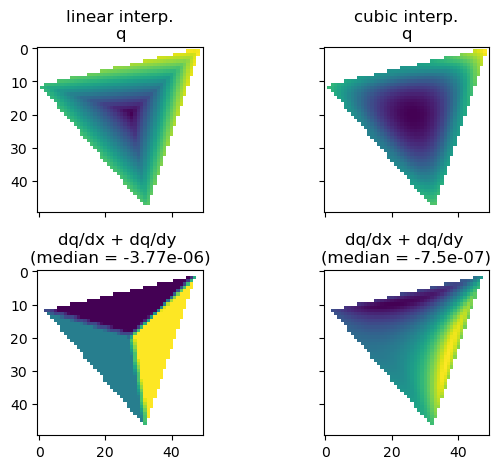

In [43]:
xx_horiz, yy_horiz = np.meshgrid(
    np.linspace(points_and_fields.x.min(), points_and_fields.x.max(), HORIZ_GRID_SPACING),
    np.linspace(points_and_fields.y.min(), points_and_fields.y.max(), HORIZ_GRID_SPACING),
)

src_linear = interpolate.griddata(
    points_and_fields.loc[3][['x','y']].values, 
    points_and_fields.loc[3]['r'], 
    (xx_horiz, yy_horiz), 
    method='linear'
)
src_cubic = interpolate.griddata(
    points_and_fields.loc[3][['x','y']].values, 
    points_and_fields.loc[3]['r'], 
    (xx_horiz, yy_horiz), 
    method='cubic'
)
src_grad_linear = (
    np.gradient(src_linear, grid_spacing[0], axis=0) + 
    np.gradient(src_linear, grid_spacing[1], axis=1)
)
src_grad_cubic = (
    np.gradient(src_cubic, grid_spacing[0], axis=0) + 
    np.gradient(src_cubic, grid_spacing[1], axis=1)
)
fig, axes = plt.subplots(2,2, sharex=True, sharey=True)
axes[0,0].imshow(src_linear)
axes[0,1].imshow(src_cubic)
axes[1,0].imshow(src_grad_linear)
axes[1,1].imshow(src_grad_cubic)
axes[0,0].set_title("linear interp.\nq")
axes[0,1].set_title("cubic interp.\nq")
axes[1,0].set_title(f"dq/dx + dq/dy \n(median = {round(np.nanmedian(src_grad_linear),8)})")
axes[1,1].set_title(f"dq/dx + dq/dy \n(median = {round(np.nanmedian(src_grad_cubic),8)})")
plt.tight_layout()

# Plot results

In [44]:
line = alt.Chart().mark_rule().encode(y=alt.datum(0))

def conservation_spatial_mean_composite_plot(src, columns, title, times_filter = None, normalize = None):
    src = src.copy(deep=True)
    if times_filter is not None:
        src = src[src.time.isin(times_filter)]
    else:
        src = src
    if normalize is not None:
        src[columns] = src[columns] * normalize
    return line + alt.Chart(
        src.reset_index()
    ).transform_fold(
        columns
    ).mark_line().encode(
        alt.X('hoursminutes(time):T').title('time'),
        alt.Y('median(value):Q'),
        alt.Color('key:N')
    ).properties(height = 200, width = 200, title=title)

In [45]:
method_3d_chart = conservation_spatial_mean_composite_plot(
        conservation_spatial_mean_df,
        [
            'advective_term_lateral', 'advective_term_vertical', 'advective_term_total', 
            'airdensityflux_term_vertical', 'turbulent_term_vertical', 'storage_change', 'source'
        ],
        title='3D Method', normalize = 7
    )
# method_2d_chart = conservation_spatial_mean_composite_plot(
#         conservation_spatial_mean_2d_df, 
#         [c for c in list(conservation_spatial_mean_2d_df.columns) if '1m' not in c], 
#         '2D Method, cubic interpolation', 
#         times_filter = None, 
#         normalize = 7
#     )

In [57]:
method_3d_chart

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


: 

In [46]:
src = conservation_spatial_mean_df.join(
    tidy_df.query("variable=='w_h2o__3m_c'")[['time', 'value']].set_index('time').rename(columns={'value':'w_h2o__3m_c'})
)
alt.Chart(
    src.reset_index()
).transform_fold(
    ['advective_term_lateral', 'w_h2o__3m_c', 'advective_term_vertical']
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Water vapor flux density (g/m^2/s)').scale(
        domain=[-0.001, 0.006]
    ),
    alt.Color('key:N').sort([
        'w_h2o__3m_c', 'advective_term_lateral', 'advective_term_vertical'
    ])
    
).properties(width = 200, height = 200).display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [47]:
method_3d_chart = conservation_spatial_mean_composite_plot(
        conservation_spatial_mean_df,
        [
            'advective_term_lateral', 
            'advective_term_vertical', 
            'advective_term_total', 
            # 'airdensityflux_term_vertical', 'turbulent_term_vertical', 'storage_change', 'source'
        ],
        title='3D Method', normalize = 7
    )

In [48]:
alt.Chart(
    conservation_spatial_mean_df.loc['20221101':'20221120'].reset_index()
).transform_fold([
    'advective_term_lateral', 
    'advective_term_vertical', 
    'advective_term_total', 
]).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q').scale(domain=[-0.1,0.1], clamp=True),
    alt.Color('key:N')
).properties(width=800)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [49]:
conservation_spatial_mean_composite_plot(
        conservation_spatial_mean_df.loc['20221101':'20221120'],
        [
            'advective_term_lateral', 
            'advective_term_vertical', 
            'advective_term_total', 
            # 'airdensityflux_term_vertical', 'turbulent_term_vertical', 'storage_change', 'source'
        ],
        title='3D Method', normalize = 7
    ) | conservation_spatial_mean_composite_plot(
        conservation_spatial_mean_df.loc['20230601':'20230619'],
        [
            'advective_term_lateral', 
            'advective_term_vertical', 
            'advective_term_total', 
            # 'airdensityflux_term_vertical', 'turbulent_term_vertical', 'storage_change', 'source'
        ],
        title='3D Method', normalize = 7
    )

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [50]:
src = continuity_spatial_mean_df.drop(columns='dryair_density')
src['conservation'] = src.sum(axis=1)
alt.Chart(src.reset_index()).transform_fold(
    list(src.columns)
).mark_line().encode(
    alt.X('hoursminutes(time):T').title('time'),
    alt.Y('median(value):Q'),
    alt.Color('key:N', legend=alt.Legend(labelLimit=1000))
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [51]:
src = tidy_df.query("measurement == 'wind speed'").query("tower == 'c'").set_index(['time', 'height'])
src = src.groupby([
    src.index.get_level_values(0).floor('120T').time, 'height'
])[['value']].mean()
src = src.reset_index().rename(columns={'level_0':'time'})
src['hour'] = src.time.apply(lambda t: t.hour)
chart = alt.Chart(
    src
).mark_line().encode(
    alt.X('value:Q').sort('-y'),
    alt.Y('height:Q'),
    alt.Color('hour:O').scale(scheme='rainbow')
).properties(width=110,height=110)
(
    chart.transform_filter(alt.FieldOneOfPredicate('hour', [0, 2,4,6])) |\
    chart.transform_filter(alt.FieldOneOfPredicate('hour', [8,10,12,14])) |\
    chart.transform_filter(alt.FieldOneOfPredicate('hour', [16,18,20,22]))
).configure_legend(orient='top').resolve_scale(color='shared')

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_13412/3952423949.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  src.index.get_level_values(0).floor('120T').time, 'height'


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [52]:
src = tidy_df.query("measurement == 'wind speed'").query("tower == 'c'")
src = src.set_index('time').loc['20230203':'20230203'].reset_index()
src = src.set_index(['time', 'height'])
src = src.groupby([
    src.index.get_level_values(0).floor('120T').time, 'height'
])[['value']].mean()
src = src.reset_index().rename(columns={'level_0':'time'})
src['hour'] = src.time.apply(lambda t: t.hour)
chart = alt.Chart(
    src
).mark_line().encode(
    alt.X('value:Q').sort('-y'),
    alt.Y('height:Q'),
    alt.Color('hour:O').scale(scheme='rainbow')
).properties(width=110,height=110)
(
    chart.transform_filter(alt.FieldOneOfPredicate('hour', [0, 2,4,6])) |\
    chart.transform_filter(alt.FieldOneOfPredicate('hour', [8,10,12,14])) |\
    chart.transform_filter(alt.FieldOneOfPredicate('hour', [16,18,20,22]))
).configure_legend(orient='top').resolve_scale(color='shared')

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_13412/1803575803.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  src.index.get_level_values(0).floor('120T').time, 'height'


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [53]:
src = tidy_df.query("measurement == 'wind direction'")
src = src.set_index('time').loc['20230203':'20230203'].reset_index()
src = src.set_index(['time', 'height', 'tower'])
src = src.groupby([
    src.index.get_level_values(0).floor('120T').time, 'height', 'tower'
])[['value']].mean()
src = src.reset_index().rename(columns={'level_0':'time'})
src['hour'] = src.time.apply(lambda t: t.hour)
chart = alt.Chart(
    src
).mark_line().encode(
    alt.X('value:Q').sort('-y'),
    alt.Y('height:Q'),
    alt.Color('hour:O').scale(scheme='rainbow'),
    alt.StrokeDash('tower:N')
).properties(width=110,height=110)
(
    chart.transform_filter(alt.FieldOneOfPredicate('hour', [0, 2,4,6])) |\
    chart.transform_filter(alt.FieldOneOfPredicate('hour', [8,10,12,14])) |\
    chart.transform_filter(alt.FieldOneOfPredicate('hour', [16,18,20,22]))
).configure_legend(orient='top').resolve_scale(x='shared', color='shared').display(renderer='svg')

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_13412/875321252.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  src.index.get_level_values(0).floor('120T').time, 'height', 'tower'


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [54]:
src = tidy_df.query("measurement == 'wind speed'")
src = src.set_index('time').loc['20230203':'20230203'].reset_index()
src = src.set_index(['time', 'height', 'tower'])
src = src.groupby([
    src.index.get_level_values(0).floor('120T').time, 'height', 'tower'
])[['value']].mean()
src = src.reset_index().rename(columns={'level_0':'time'})
src['hour'] = src.time.apply(lambda t: t.hour)
chart = alt.Chart(
    src
).mark_line().encode(
    alt.X('value:Q').sort('-y'),
    alt.Y('height:Q'),
    alt.Color('hour:O').scale(scheme='rainbow'),
    alt.StrokeDash('tower:N')
).properties(width=110,height=110)
(
    chart.transform_filter(alt.FieldOneOfPredicate('hour', [0, 2,4,6])) |\
    chart.transform_filter(alt.FieldOneOfPredicate('hour', [8,10,12,14])) |\
    chart.transform_filter(alt.FieldOneOfPredicate('hour', [16,18,20,22]))
).configure_legend(orient='top').resolve_scale(color='shared').display(renderer='svg')

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_13412/349792119.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  src.index.get_level_values(0).floor('120T').time, 'height', 'tower'


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [55]:
(
    conservation_spatial_mean_composite_plot(
        conservation_spatial_mean_df.reset_index(),
        [
            'advective_term_lateral', 'advective_term_vertical', 'advective_term_total', 
            'airdensityflux_term_vertical', 'turbulent_term_vertical', 'storage_change', 'source'
        ],
        title='All data', normalize = 7
    ) | conservation_spatial_mean_composite_plot(
        conservation_spatial_mean_df.reset_index(),
        [
            'advective_term_lateral', 'advective_term_vertical', 'advective_term_total', 
            'airdensityflux_term_vertical', 'turbulent_term_vertical', 'storage_change', 'source'
        ],
        title='No BS', normalize = 7,
        times_filter = set(nobs_times)
    ) | conservation_spatial_mean_composite_plot(
        conservation_spatial_mean_df.reset_index(),
        [
            'advective_term_lateral', 'advective_term_vertical', 'advective_term_total', 
            'airdensityflux_term_vertical', 'turbulent_term_vertical', 'storage_change', 'source'
        ],
        title='No BS, not snowing', normalize = 7,
        times_filter = set(nobs_times).intersection(set(is_not_snowing_dates))
    ) | conservation_spatial_mean_composite_plot(
        conservation_spatial_mean_df.reset_index(),
        [
            'advective_term_lateral', 'advective_term_vertical', 'advective_term_total', 
            'airdensityflux_term_vertical', 'turbulent_term_vertical', 'storage_change', 'source'
        ],
        title='Not snowing', normalize = 7,
        times_filter = set(is_not_snowing_dates)
    ) | conservation_spatial_mean_composite_plot(
        conservation_spatial_mean_df.reset_index(),
        [
            'advective_term_lateral', 
            'advective_term_vertical', 
            'advective_term_total', 
            'airdensityflux_term_vertical', 
            'turbulent_term_vertical', 
            'storage_change', 'source'
        ],
        title='BS', normalize = 7,
        times_filter = set(bs_times)
    )
).resolve_scale(y='shared', x='shared', color='shared').display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [56]:
(
    conservation_spatial_mean_composite_plot(
        conservation_spatial_mean_df,
        [
            'advective_term_lateral', 'advective_term_vertical', 'advective_term_total', 
            'airdensityflux_term_vertical', 'turbulent_term_vertical', 'storage_change', 'source'
        ],
        title='All data', normalize = 7
    ) | conservation_spatial_mean_composite_plot(
        conservation_spatial_mean_df,
        [
            'advective_term_lateral', 'advective_term_vertical', 'advective_term_total', 
            'airdensityflux_term_vertical', 'turbulent_term_vertical', 'storage_change', 'source'
        ],
        title='Stable, No BS', normalize = 7,
        times_filter = set(tgrad_stable_times).intersection(set(nobs_times))
    ) | conservation_spatial_mean_composite_plot(
        conservation_spatial_mean_df,
        [
            'advective_term_lateral', 'advective_term_vertical', 'advective_term_total', 
            'airdensityflux_term_vertical', 'turbulent_term_vertical', 'storage_change', 'source'
        ],
        title='Neutral, No BS', normalize = 7,
        times_filter = set(tgrad_neutral_times).intersection(set(nobs_times))
    ) | conservation_spatial_mean_composite_plot(
        conservation_spatial_mean_df,
        [
            'advective_term_lateral', 'advective_term_vertical', 'advective_term_total', 
            'airdensityflux_term_vertical', 'turbulent_term_vertical', 'storage_change', 'source'
        ],
        title='Unstable, No BS', normalize = 7,
        times_filter = set(tgrad_unstable_times).intersection(set(nobs_times))
    )
).resolve_scale(y='shared', x='shared', color='shared').display(renderer='svg')

AttributeError: 'DataFrame' object has no attribute 'time'

In [ ]:
(
    conservation_spatial_mean_composite_plot(
        conservation_spatial_mean_df,
        [
            'advective_term_lateral', 'advective_term_vertical', 'advective_term_total', 
            'airdensityflux_term_vertical', 'turbulent_term_vertical', 'storage_change',	'source'
        ],
        title='Flux density terms (g/m^2/s)', normalize = 7,
        times_filter = set(nobs_times)
    ) 
    | 
    alt.Chart(
        tidy_df[
            tidy_df.variable.isin(['w_h2o__3m_c', 'w_h2o__5m_c', 'w_h2o__10m_c'])
            &
            tidy_df.time.isin(set(nobs_times))
        ]
    ).mark_line().encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('median(value):Q'),
        alt.Color('height:O')
    ).properties(
        width = 200, height = 200, title=('Vertical eddy covariance flux (g/m^2/s)')
    )
).resolve_scale(y='shared', color='independent').configure_legend(orient='top', columns=2).display(renderer='svg')

In [ ]:

src1 = conservation_spatial_mean_df.set_index('time').loc['20221221': '20221223'].reset_index().assign(casestudy = 1)
src2 = conservation_spatial_mean_df.set_index('time').loc['20221212': '20221214'].reset_index().assign(casestudy = 2)
src3 = conservation_spatial_mean_df.set_index('time').loc['20230201': '20230203'].reset_index().assign(casestudy = 3)
src = pd.concat([src1, src2, src3])
alt.Chart(src).transform_fold([
    'advective_term_lateral', 'advective_term_vertical',
    'advective_term_total', 'airdensityflux_term_vertical',
    'turbulent_term_vertical', 'storage_change', 'source',
]).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q').scale(domain=[-0.04,0.04], clamp=True),
    alt.Color('key:N'),
    alt.Facet('casestudy:N').title(None)
).properties(width = 300, height = 200).resolve_scale(x='independent').display(renderer='svg')

In [ ]:
alt.Chart(
    conservation_spatial_mean_df.set_index('time').loc['20230401': '20230407'].reset_index()
).transform_fold([
    'advective_term_lateral', 'advective_term_vertical',
    'advective_term_total', 'airdensityflux_term_vertical',
    'turbulent_term_vertical', 'storage_change', 'source',
]).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q').scale(domain=[-0.04,0.04], clamp=True),
    alt.Color('key:N'),
    alt.Facet('casestudy:N').title(None)
).properties(width =600, height = 200).resolve_scale(x='independent').display(renderer='svg')

In [ ]:
(
    (
        alt.Chart(
            (conservation_spatial_mean_df.set_index('time') * 7).loc['20230202': '20230204'].reset_index().assign(casestudy = 3)
        ).transform_fold([
            'advective_term_lateral', 
            'advective_term_vertical',
            # 'advective_term_total', 
            'airdensityflux_term_vertical',
            'turbulent_term_vertical', 
            # 'storage_change', 
            # 'source',
        ]).mark_line().encode(
            alt.X('time:T').axis(None),
            alt.Y('value:Q').scale(domain=[-0.1,0.1], clamp=True).title('Flux density (g/m^2/s)'),
            alt.Color('key:N'),
            alt.Facet('casestudy:N').title(None)
        ).properties(width = 800, height = 200) &\
        alt.Chart(
            tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time').loc['20230202': '20230204'].reset_index()
        ).mark_line().encode(
            alt.X('time:T').axis(None),
            alt.Y('value:Q').title(["Vertical eddy cov.", "flux density (g/m^2/s)"]),
            alt.Color('height:O')
        ).properties(width = 800, height = 100)
     ).resolve_scale(y='shared') &\
    alt.Chart(
        tidy_df.query("measurement == 'wind direction'").query("tower == 'c'").query(
            "height <= 10"
        ).set_index('time').loc['20230202': '20230204'].reset_index()
    ).mark_line().encode(
        alt.X('time:T').axis(None),
        alt.Y('value:Q').title('Wind Dir. (˚)'),
        alt.Color('height:O')
    ).properties(width = 800, height = 100) &\
    alt.Chart(
        tidy_df.query("variable == 'Ri_3m_c'").set_index('time').loc['20230202': '20230204'].reset_index()
    ).mark_line().encode(
        alt.X('time:T').axis(None),
        alt.Y('value:Q').scale(type='symlog', domain=[-10,10], clamp=True).title('Ri (at 3 meters)'),
        alt.Color('height:O')
    ).properties(width = 800, height = 100) &\
    alt.Chart(
        tidy_df.query("variable == 'spd_10m_c'").set_index('time').loc['20230202': '20230204'].reset_index()
    ).mark_line().encode(
        alt.X('time:T'),
        alt.Y('value:Q').title('Wind speed (m/s)'),
        alt.Color('height:O')
    ).properties(width = 800, height = 100)
).resolve_scale(color='independent')

In [ ]:
alt.Chart(
    tidy_df.query("measurement == 'wind direction'").query("tower == 'c'").query(
        "height <= 10"
    ).set_index('time').loc['20221221': '20221223'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('height:O')
).properties(width = 300, height = 200) | alt.Chart(
    tidy_df.query("measurement == 'wind direction'").query("tower == 'c'").query(
        "height <= 10"
    ).set_index('time').loc['20221212': '20221214'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('height:O')
).properties(width = 300, height = 200) | alt.Chart(
    tidy_df.query("measurement == 'wind direction'").query("tower == 'c'").query(
        "height <= 10"
    ).set_index('time').loc['20230201': '20230203'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('height:O')
).properties(width = 300, height = 200)

In [ ]:
src = tidy_df[
    tidy_df.time.isin(
        set(nobs_times).intersection(set(is_not_snowing_dates))
    )
]
src = src[src.variable.isin(['w_h2o__3m_c', 'w_h2o__5m_c', 'w_h2o__10m_c'])]
alt.Chart(
    src
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('height:O')
).properties(height = 200, width = 200, title='Vertical turbulent flux (g/m^2/s)')

In [ ]:
alt.Chart(
    tidy_df.query("measurement == 'air density'").query("height > 0")
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').scale(zero=False),
    alt.Color('height:O')
) | alt.Chart(
    tidy_df.query("measurement == 'temperature'").query("height > 0")
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').scale(zero=False),
    alt.Color('height:O')
)

In [ ]:
src = mixing_ratio_field_df.copy()
src.columns = src.columns.droplevel(2)
src.columns = [f"{int(c1)}_{c2}" for (c1,c2) in zip(
    src.columns.get_level_values(0),
    src.columns.get_level_values(1)
)]
src = src.melt(ignore_index=False)
src['height'] = src['variable'].apply(lambda s: int(s.split('_')[0]))
src['tower'] = src['variable'].apply(lambda s: s.split('_')[1])
src = src[src.tower != 'c']
daily_mixingratio_chart = alt.Chart(src.reset_index()).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').scale(zero=False),
    alt.Color('tower:N'),
    alt.StrokeDash('height:O'),
).properties(title='Daily composite water vapor mixing ratio (g/g)')

In [ ]:
src = mixing_ratio_field_df.copy()
src.columns = src.columns.droplevel(2)
src.columns = [f"{int(c1)}_{c2}" for (c1,c2) in zip(
    src.columns.get_level_values(0),
    src.columns.get_level_values(1)
)]
src = src.melt(ignore_index=False)
src['height'] = src['variable'].apply(lambda s: int(s.split('_')[0]))
src['tower'] = src['variable'].apply(lambda s: s.split('_')[1])
src = src.reset_index()
src = src[(src.time > '20230201') & (src.time < '20230205')]
src = src.query("height == 3")
src.to_csv('irga_mixingratio_estimates.csv')
alt.Chart(src).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('tower:N')
).properties()

In [ ]:
src = mixing_ratio_field_df.copy()
src.columns = src.columns.droplevel(2)
src.columns = [f"{int(c1)}_{c2}" for (c1,c2) in zip(
    src.columns.get_level_values(0),
    src.columns.get_level_values(1)
)]
src = src.melt(ignore_index=False)
src['height'] = src['variable'].apply(lambda s: int(s.split('_')[0]))
src['tower'] = src['variable'].apply(lambda s: s.split('_')[1])
src = src.reset_index()
src = src[(src.time > '20221201') & (src.time < '20221205')]
src = src.query("height == 3")
src.to_csv('irga_mixingratio_estimates_2.csv')
alt.Chart(src).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('tower:N')
).properties()

In [ ]:
src

In [ ]:
src = dryair_density_field_df.copy()
src.columns = src.columns.droplevel(2)
src.columns = [f"{int(c1)}_{c2}" for (c1,c2) in zip(
    src.columns.get_level_values(0),
    src.columns.get_level_values(1)
)]
src = src.melt(ignore_index=False)
src['height'] = src['variable'].apply(lambda s: int(s.split('_')[0]))
src['tower'] = src['variable'].apply(lambda s: s.split('_')[1])
src = src.reset_index()
src = src[(src.time > '20230201') & (src.time < '20230205')]
src = src.query("height == 3")
alt.Chart(src).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q').scale(zero=False),
    alt.Color('tower:N')
).properties()

In [ ]:
tc_field_df = tidy_df[tidy_df.measurement.isin(['virtual temperature']) & tidy_df.height.isin(HEIGHTS)]
tc_field_df.measurement = 'tc'
tc_field_df = round(
    tc_field_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    ), 
    4
)

src = tc_field_df.copy()
src.columns = src.columns.droplevel(2)
src.columns = [f"{int(c1)}_{c2}" for (c1,c2) in zip(
    src.columns.get_level_values(0),
    src.columns.get_level_values(1)
)]
src = src.melt(ignore_index=False)
src['height'] = src['variable'].apply(lambda s: int(s.split('_')[0]))
src['tower'] = src['variable'].apply(lambda s: s.split('_')[1])
src = src[src.tower != 'c']
daily_sonic_temp_chart = alt.Chart(src.reset_index()).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').scale(zero=False
                                   ),
    alt.Color('tower:N'),
    alt.StrokeDash('height:O'),
).properties(title='Daily composite sonic temperature (˚C)')

In [ ]:
(daily_mixingratio_chart | daily_sonic_temp_chart
).display(renderer='svg')